<a href="https://colab.research.google.com/github/HAMZA310/-CS231n-Convolutional-Neural-Networks-for-Visual-Recognition-STANFORD/blob/master/hw-3/notebook/updated_copy_hw3_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 1
#### d) 
Write a Python function to compute the gradients of this function given input
$w_i$ and $x_i$ efficiently with backpropagation. (Write it from scratch.)

In [2]:
def compute_gradient_of_max_fn(params):
    """
    Computes gradient of the function: max(w0, w1x1, w2x2, 0)
    
    
    args: params -> tuple of len 5 => (w0, w1, x1, w2, x2)
    
    returns -> tuple of len 5 => (dw0, dw1, dx1, dw2, dx2) => gradient => 
                            parital derivatives w.r.t to f of w0, w1, x1, w2, x2
                            respectively.
    """
    
    # unpack params 
    w0, w1, x1, w2, x2 = params
    
    # define a var z
    z = w0 + w1*x1 + w2*x2
    
    # Initialize partial derivatives of each parameter w.r.t. fn to 0.
    dw0, dw1, dx1, dw2, dx2 = (0,0,0,0,0)
    
    # if z is less or equal to 0, we're done. Gradient is a vector of 0s.
    if z <= 0:
        gradient = (dw0, dw1, dx1, dw2, dx2)
        
    # if z is greater than 0, then compute partial derivatives 
    else:
        # partial derivative of f w.r.t. w0
        dw0 = 1
        # partial derivative of f w.r.t. w1
        dw1 = x1
        # partial derivative of f w.r.t. x1
        dx1 = w1
        # partial derivative of f w.r.t. w2
        dw2 = x2
        # partial derivative of f w.r.t. x2
        dx2 = w2
        gradient = (dw0, dw1, dx1, dw2, dx2)
    
    return gradient

#### Test this function

In [3]:
_params = (5, -4, 2, -3, -2) # test on paramters given in part a of Q-1

compute_gradient_of_max_fn(_params)

(1, 2, -4, -2, -3)

In [4]:
_params = (10, -2, 4, -3, 2) # test on paramters given in part a of Q-1

compute_gradient_of_max_fn(_params)

(0, 0, 0, 0, 0)

Both gradients match to my response to `part a` and `part b` of `Q-1` respectively.


## Question 2

In [5]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

In [6]:
class FeedforwardNeuralNetworkSGD:
    
    # input a vector [a, b, c, ...] with the number of nodes in each layer
    def __init__(self, layers, alpha = 0.1, batchSize = 32):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # batch size
        self.batchSize = batchSize
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1))
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1]))
        
    # define the sigmoid activation
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the sigmoid derivative (where z is the output of a sigmoid)
    def sigmoidDerivative(self, z):
        return z * (1 - z)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))

        # history keeps track of all loss/accuracy vs epoch number on Test data
        loss_history = []
        accuracy_history = []

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.sigmoid(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                D = [error * self.sigmoidDerivative(A[-1])]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.sigmoidDerivative(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * A[layer].T.dot(D[layer])
            
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)
                print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))


################ Show test accuracy and record test accuracy and loss for plotting later ################
            loss_Test = self.computeLoss(testX, testY, addOnes=True)
            loss_history.append(loss_Test)

            accuracy_testX = self.get_testing_accuracy(testX, testY, epoch)
            accuracy_history.append(accuracy_testX)

        return loss_history, accuracy_history
################ Show test accuracy and record test accuracy and loss for plotting later ################




################ Member function to Display Test Accuracy for each epoch ################
    def get_testing_accuracy(self, testX, testY, epoch):
        predictedY = self.predict(testX)
        predictedY = predictedY.argmax(axis=1)

        testY = testY.argmax(axis=1)

        accuracy_on_testX = accuracy_score(testY, predictedY)
        report = classification_report(testY, predictedY)
        print("[INFO] epoch = {}, accuracy = {}, classification report :\n {}".format(epoch + 1, 
                                                                    accuracy_on_testX, report))
        return accuracy_on_testX
################ Member function to Display Test Accuracy for each epoch ################


    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            # print('shapes, p and ws', p.shape, self.W[layer].shape)
            p = self.sigmoid(np.dot(p, self.W[layer]))
            
        return p
    
    def computeLoss(self, X, y, addOnes=False):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = addOnes)
        loss = np.sum((predictions - y)**2) / 2.0
        
        return loss

In [7]:
### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:10000].reshape([10000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print(trainX.shape)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([784, 256, 128, 64, 10], 0.5, 32)
#model = FeedforwardNeuralNetworkSGD([64, 16, 16, 10], 0.5, 32)
loss_history, accuracy_history = model.fit(trainX, trainY, testX, testY, 1000, 100)



(7500, 784)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.
           5       0.13      0.33      0.19       215
           6       0.20      0.03      0.06       263
           7       0.00      0.00      0.00       282
           8       0.00      0.00      0.00       247
           9       0.00      0.00      0.00       221

    accuracy                           0.11      2500
   macro avg       0.14      0.12      0.04      2500
weighted avg       0.15      0.11      0.04      2500

[INFO] epoch = 724, accuracy = 0.1144, classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       256
           1       1.00      0.00      0.01       268
           2       0.00      0.00      0.00       260
           3       0.00      0.00      0.00       250
           4       0.11      0.86      0.19       238
           5       0.13      0.33      0.19       215
           6       0.20      0.03      0.06       263
           7      

### Plots

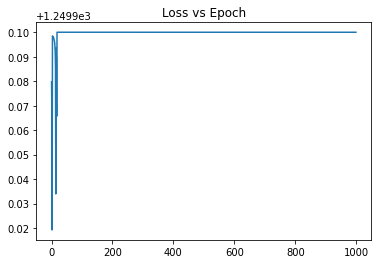

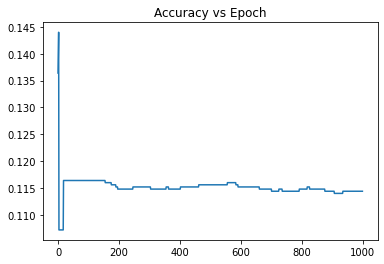

Training set accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       745
           1       1.00      0.00      0.01       859
           2       0.00      0.00      0.00       731
           3       0.00      0.00      0.00       782
           4       0.11      0.90      0.20       742
           5       0.11      0.26      0.16       648
           6       0.20      0.04      0.07       751
           7       0.00      0.00      0.00       788
           8       0.00      0.00      0.00       697
           9       0.00      0.00      0.00       757

    accuracy                           0.12      7500
   macro avg       0.14      0.12      0.04      7500
weighted avg       0.16      0.12      0.04      7500

Test set accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       256
           1       0.00      0.00      0.00       268
           2       0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Plot Loss vs epoch
plt.plot(loss_history)
plt.title('Loss vs Epoch')
plt.show()

# Plot test accuracy vs epoch
plt.plot(accuracy_history)
plt.title('Accuracy vs Epoch')
plt.show()

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

trainY = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

## Question 3

In [9]:
class FeedforwardNeuralNetworkSGDWithRegularization:
    
    # input a vector [a, b, c, ...] with the number of nodes in each layer
    def __init__(self, layers, alpha = 0.1, batchSize = 32):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha

        # Regularization parameter
        self.lambda_ = 0.1
        
        # batch size
        self.batchSize = batchSize
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1))
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1]))
        
    # define the sigmoid activation
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the sigmoid derivative (where z is the output of a sigmoid)
    def sigmoidDerivative(self, z):
        return z * (1 - z)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))

        # history keeps track of all loss/accuracy vs epoch number on Test data
        loss_history = []
        accuracy_history = []

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.sigmoid(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation 
                error = A[-1] - target
                
                D = [error * self.sigmoidDerivative(A[-1])]
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A)-2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.sigmoidDerivative(A[layer])
                    D.append(delta)

                # reverse the deltas since we looped in reverse
                D = D[::-1]


################ Weight update with regularization incorporated ################
                for layer in np.arange(0, len(self.W)):
                    "Add the extra regularization term"
                    self.W[layer] -= self.alpha  *  (A[layer].T.dot(D[layer])+self.lambda_*self.W[layer])
################ Weight update with regularization incorporated ################



################ Loss update to incorporate L-2 Regularization ################
            Ws_sq_sum = 0
            for i in range(len(self.W)):
                Ws_sq_sum += np.sum(self.W[i]**2)

            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y) + Ws_sq_sum
                print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
################ Loss update to incorporate L-2 Regularization ################

            loss_Test = self.computeLoss(testX, testY, addOnes=True) + Ws_sq_sum
            loss_history.append(loss_Test)

            accuracy_testX = self.get_testing_accuracy(testX, testY, epoch)
            accuracy_history.append(accuracy_testX)

        return loss_history, accuracy_history


    def get_testing_accuracy(self, testX, testY, epoch):
        predictedY = self.predict(testX)
        predictedY = predictedY.argmax(axis=1)

        testY = testY.argmax(axis=1)

        accuracy_on_testX = accuracy_score(testY, predictedY)
        "Uncomment below to display classification report for Test data"
        # report = classification_report(testY, predictedY)
        # print("[INFO] epoch = {}, accuracy = {}, classification report :\n {}".format(epoch + 1, 
        #                                                             accuracy_on_testX, report))
        return accuracy_on_testX

    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.sigmoid(np.dot(p, self.W[layer]))
            
        return p
    
    def computeLoss(self, X, y, addOnes=False):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = addOnes)
        loss = np.sum((predictions - y)**2) / 2.0
        
        return loss

In [10]:

### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:10000].reshape([10000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGDWithRegularization([784, 256, 128, 64, 10], 0.5, 32)
#model = FeedforwardNeuralNetworkSGD([64, 16, 16, 10], 0.5, 32)
loss_history, accuracy_history = model.fit(trainX, trainY, testX, testY, 1000, 100)



[INFO] epoch = 100, loss = 3736.302477
[INFO] epoch = 200, loss = 4659.652868
[INFO] epoch = 300, loss = 3596.506005
[INFO] epoch = 400, loss = 3595.196957
[INFO] epoch = 500, loss = 3587.613891
[INFO] epoch = 600, loss = 3483.370206
[INFO] epoch = 700, loss = 3486.339113
[INFO] epoch = 800, loss = 3462.045484
[INFO] epoch = 900, loss = 3593.609058
[INFO] epoch = 1000, loss = 3541.023578


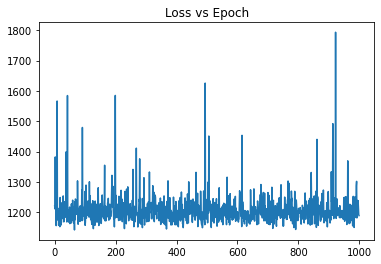

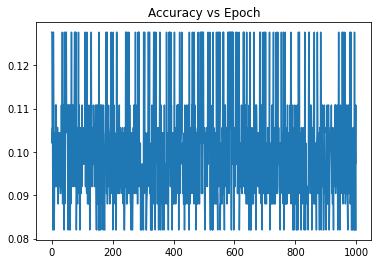

Training set accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       771
           1       0.00      0.00      0.00       808
           2       0.00      0.00      0.00       730
           3       0.00      0.00      0.00       777
           4       0.00      0.00      0.00       760
           5       0.09      1.00      0.16       658
           6       0.00      0.00      0.00       750
           7       0.00      0.00      0.00       793
           8       0.00      0.00      0.00       718
           9       0.00      0.00      0.00       735

    accuracy                           0.09      7500
   macro avg       0.01      0.10      0.02      7500
weighted avg       0.01      0.09      0.01      7500

Test set accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.00      0.00      0.00       319
           2       0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Plot Loss vs epoch
plt.plot(loss_history)
plt.title('Loss vs Epoch')
plt.show()

# Plot test accuracy vs epoch
plt.plot(accuracy_history)
plt.title('Accuracy vs Epoch')
plt.show()

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

trainY = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# Question 4
`Add options to choose between several activation functions: sigmoid, ReLU, and exponential linear unit and run each setting on MNIST to see if there are differences in classification performance or computational time. Generate the same plots.`

### Answer
Since it's not specified whether I should use a different activation for the output layer, for simplicity, I'll assume the same activation function for all layers. However, I understand that for the output layer ReLU/ELU might not be the best choice.

In [14]:
class FeedforwardNeuralNetworkSGDWithDiffActivations:
    
    # input a vector [a, b, c, ...] with the number of nodes in each layer
    def __init__(self, layers, alpha = 0.1, batchSize = 32, activation_fn_ID=1):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # batch size
        self.batchSize = batchSize


########################## Instantiate the Model with the desired Activation Function #############
        # Activation functions optionality
        if activation_fn_ID == 1:
            print('using sigmoid')
            self.activation_fn = self.sigmoid
            self.activation_fn_derivative = self.sigmoidDerivative
        elif activation_fn_ID == 2:
            print('using relu')
            self.activation_fn = self.ReLU
            self.activation_fn_derivative = self.ReLUDerivative
        elif activation_fn_ID == 3:
            print('using elu')
            self.activation_fn = self.ELU
            self.activation_fn_derivative = self.ELUDerivative
########################## Instantiate the Model with the desired Activation Function #############



        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1))
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1]))
        
    # define the sigmoid activation
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the sigmoid derivative (where z is the output of a sigmoid)
    def sigmoidDerivative(self, z):
        return z * (1 - z)


########################## Additional Activation Functions Defined ####################
    # define the ReLu activation
    def ReLU(self, x):
        out = x * (x>0) # keep only elements which are greater than zero
        return out

    # define the ReLu derivative
    def ReLUDerivative(self, x):
        dx = 1 * (x>0) 
        return dx
    
    # define the Exponential linear unit activation
    def ELU(self, x, alpha=0.1):
        return np.where(x>0, x, alpha*np.exp(x)-1)
        
    # define the ELU derivative
    def ELUDerivative(self, x, alpha=0.1):
        return np.where(x>0, 1, alpha*np.exp(x))
########################## Additional Activation Functions Defined ####################


    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))

        # history keeps track of all loss/accuracy vs epoch number on Test data
        loss_history = []
        accuracy_history = []

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activation_fn(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                D = [error * self.activation_fn_derivative(A[-1])]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activation_fn_derivative(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * A[layer].T.dot(D[layer])
            
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)
                print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))

            # print(testX.shape, testY.shape, "<< check shapes")
            loss_Test = self.computeLoss(testX, testY, addOnes=True)
            loss_history.append(loss_Test)

            accuracy_testX = self.get_testing_accuracy(testX, testY, epoch)
            accuracy_history.append(accuracy_testX)

        return loss_history, accuracy_history

    def get_testing_accuracy(self, testX, testY, epoch):
        predictedY = self.predict(testX)
        predictedY = predictedY.argmax(axis=1)

        testY = testY.argmax(axis=1)

        accuracy_on_testX = accuracy_score(testY, predictedY)
        "Uncomment to display classification Report of each epoch."
        # report = classification_report(testY, predictedY)
        # print("[INFO] epoch = {}, accuracy = {}, classification report :\n {}".format(epoch + 1, 
        #                                                             accuracy_on_testX, report))
        return accuracy_on_testX

    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            # print('shapes, p and ws', p.shape, self.W[layer].shape)
            p = self.activation_fn(np.dot(p, self.W[layer]))
            
        return p
    
    def computeLoss(self, X, y, addOnes=False):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = addOnes)
        loss = np.sum((predictions - y)**2) / 2.0
        
        return loss

#### Activation functions 
To instantiate a model
- with `1` as activation_fn ID, will use `sigmoid`
- with `2` as activation_fn ID, will use `ReLU`
- with `3` as activation_fn ID, will use `ELU`

(7500, 784)
using sigmoid
[INFO] epoch = 100, loss = 3749.999504
[INFO] epoch = 200, loss = 3749.996493
[INFO] epoch = 300, loss = 3749.999984
[INFO] epoch = 400, loss = 3749.999983
[INFO] epoch = 500, loss = 3749.999983
[INFO] epoch = 600, loss = 3749.999983
[INFO] epoch = 700, loss = 3749.999983
[INFO] epoch = 800, loss = 3749.999982
[INFO] epoch = 900, loss = 3749.999982
[INFO] epoch = 1000, loss = 3749.999982


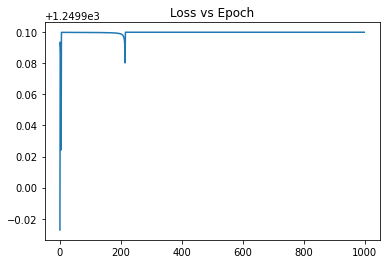

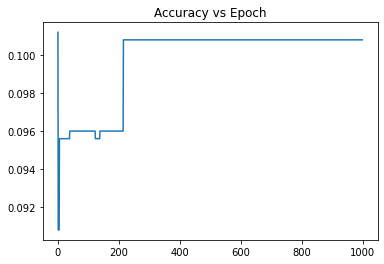

Training set accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       755
           1       0.06      0.00      0.01       852
           2       0.00      0.00      0.00       743
           3       0.00      0.00      0.00       752
           4       0.00      0.00      0.00       737
           5       0.19      0.00      0.01       636
           6       0.10      1.00      0.19       761
           7       0.00      0.00      0.00       807
           8       0.00      0.00      0.00       719
           9       0.00      0.00      0.00       738

    accuracy                           0.10      7500
   macro avg       0.03      0.10      0.02      7500
weighted avg       0.03      0.10      0.02      7500

Test set accuracy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.00      0.00      0.00       275
           2       0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
"With Sigmoid Activation Function"

### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:10000].reshape([10000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print(trainX.shape)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGDWithDiffActivations([784, 256, 128, 64, 10], 0.5, 32, 1)
#model = FeedforwardNeuralNetworkSGD([64, 16, 16, 10], 0.5, 32)
loss_history, accuracy_history = model.fit(trainX, trainY, testX, testY, 1000, 100)

# Plot Loss vs epoch
plt.plot(loss_history)
plt.title('Loss vs Epoch')
plt.show()

# Plot test accuracy vs epoch
plt.plot(accuracy_history)
plt.title('Accuracy vs Epoch')
plt.show()

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

trainY = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

(7500, 784)
using relu
[INFO] epoch = 100, loss = 3750.000000
[INFO] epoch = 200, loss = 3750.000000
[INFO] epoch = 300, loss = 3750.000000
[INFO] epoch = 400, loss = 3750.000000
[INFO] epoch = 500, loss = 3750.000000
[INFO] epoch = 600, loss = 3750.000000
[INFO] epoch = 700, loss = 3750.000000
[INFO] epoch = 800, loss = 3750.000000
[INFO] epoch = 900, loss = 3750.000000
[INFO] epoch = 1000, loss = 3750.000000


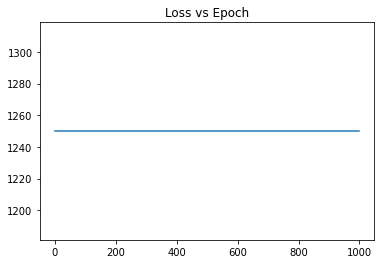

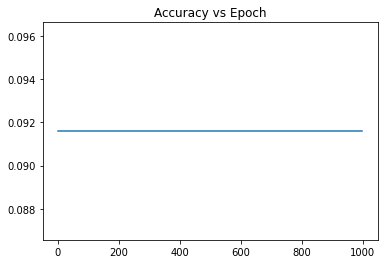

Training set accuracy
              precision    recall  f1-score   support

           0       0.10      1.00      0.19       772
           1       0.00      0.00      0.00       831
           2       0.00      0.00      0.00       751
           3       0.00      0.00      0.00       746
           4       0.00      0.00      0.00       742
           5       0.00      0.00      0.00       662
           6       0.00      0.00      0.00       761
           7       0.00      0.00      0.00       797
           8       0.00      0.00      0.00       710
           9       0.00      0.00      0.00       728

    accuracy                           0.10      7500
   macro avg       0.01      0.10      0.02      7500
weighted avg       0.01      0.10      0.02      7500

Test set accuracy
              precision    recall  f1-score   support

           0       0.09      1.00      0.17       229
           1       0.00      0.00      0.00       296
           2       0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
"With ReLU Activation Function"

### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:10000].reshape([10000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print(trainX.shape)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGDWithDiffActivations([784, 256, 128, 64, 10], 0.5, 32, 2)
#model = FeedforwardNeuralNetworkSGD([64, 16, 16, 10], 0.5, 32)
loss_history, accuracy_history = model.fit(trainX, trainY, testX, testY, 1000, 100)

# Plot Loss vs epoch
plt.plot(loss_history)
plt.title('Loss vs Epoch')
plt.show()

# Plot test accuracy vs epoch
plt.plot(accuracy_history)
plt.title('Accuracy vs Epoch')
plt.show()

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

trainY = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

`Warning`: In our case, when using ELU activation for all layers, activations get too big, and exponential overflow occurs.

(7500, 784)
using elu


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


[INFO] epoch = 100, loss = nan
[INFO] epoch = 200, loss = nan
[INFO] epoch = 300, loss = nan
[INFO] epoch = 400, loss = nan
[INFO] epoch = 500, loss = nan
[INFO] epoch = 600, loss = nan
[INFO] epoch = 700, loss = nan
[INFO] epoch = 800, loss = nan
[INFO] epoch = 900, loss = nan
[INFO] epoch = 1000, loss = nan


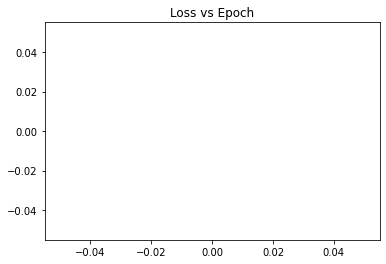

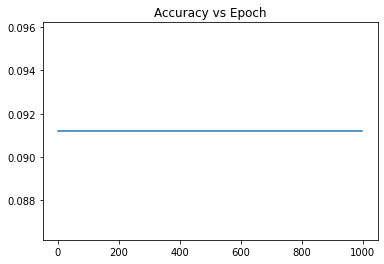

Training set accuracy
              precision    recall  f1-score   support

           0       0.10      1.00      0.19       773
           1       0.00      0.00      0.00       842
           2       0.00      0.00      0.00       735
           3       0.00      0.00      0.00       768
           4       0.00      0.00      0.00       731
           5       0.00      0.00      0.00       645
           6       0.00      0.00      0.00       745
           7       0.00      0.00      0.00       810
           8       0.00      0.00      0.00       708
           9       0.00      0.00      0.00       743

    accuracy                           0.10      7500
   macro avg       0.01      0.10      0.02      7500
weighted avg       0.01      0.10      0.02      7500

Test set accuracy
              precision    recall  f1-score   support

           0       0.09      1.00      0.17       228
           1       0.00      0.00      0.00       285
           2       0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
"With ELU Activation Function"

### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels
data = mnist.load_data()

# The datapoints are in mnistData[0][0]
X = data[0][0][:10000].reshape([10000,28*28])
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:10000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25)

print(trainX.shape)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGDWithDiffActivations([784, 256, 128, 64, 10], 0.5, 32, 3)
#model = FeedforwardNeuralNetworkSGD([64, 16, 16, 10], 0.5, 32)
loss_history, accuracy_history = model.fit(trainX, trainY, testX, testY, 1000, 100)

# Plot Loss vs epoch
plt.plot(loss_history)
plt.title('Loss vs Epoch')
plt.show()

# Plot test accuracy vs epoch
plt.plot(accuracy_history)
plt.title('Accuracy vs Epoch')
plt.show()

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

trainY = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))